In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tqdm import tqdm
import json

In [2]:
with open(r"data/ATE_Train.json", 'r') as f:
    train_data = json.load(f)

with open(r'data/ATE_Val.json', 'r') as f:
    val_data = json.load(f)
    
with open(r'data/ATE_Test.json', 'r') as f:
    test_data = json.load(f)

In [3]:
word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [4]:
def convert_data_to_tensors(data, word_vectors):
    texts = [data[key]['text'] for key in data]

    # Convert texts to word embeddings
    embeddings = []
    for text in texts:
        embedding = []
        for word in text.split():
            if word in word_vectors:
                embedding.append(word_vectors[word])
            else:
                embedding.append([0] * len(word_vectors['hello']))  # Use a zero vector for unknown words
        embeddings.append(embedding)

    # Pad sequences to have the same length
    max_len = 83 # maximum length of word in 1 text 
    padded_embeddings = []
    for embedding in embeddings:
        padded_embedding = embedding + [[0] * len(word_vectors['hello'])] * (max_len - len(embedding))
        padded_embeddings.append(padded_embedding)

    input_ids = torch.tensor(padded_embeddings)

    return input_ids

In [5]:

x_train = convert_data_to_tensors(train_data, word_vectors)
x_val = convert_data_to_tensors(val_data, word_vectors)
x_test = convert_data_to_tensors(test_data, word_vectors)

/tmp/ipykernel_33290/3668873182.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/torch/csrc/utils/tensor_new.cpp:275.)
  input_ids = torch.tensor(padded_embeddings)


In [6]:
x_train.size()

torch.Size([906, 83, 300])

In [7]:
def convert_labels_to_fixed_length(labels, max_length):
    new_list=[]
    label_to_index = {'B': 0, 'I': 1, 'O': 2,'<pad>':3}
    num_labels = len(label_to_index)
    fixed_length_labels = np.zeros((len(labels), max_length))
    for i, example_labels in enumerate(labels):
        for j, label in enumerate(example_labels[:max_length]):
            fixed_length_labels[i, j] = label_to_index[label]
        for k in range(len(example_labels[:max_length]),max_length):
            fixed_length_labels[i, k] = 3
        new_list.append(len(example_labels[:max_length]))
    return fixed_length_labels,new_list

max_length = 83
train_labels = [train_data[key]['labels'] for key in train_data]
train_lab,length_train = convert_labels_to_fixed_length(train_labels, max_length)
y_train = torch.tensor(train_lab)


val_labels = [val_data[key]['labels'] for key in val_data]
val_lab,length_val = convert_labels_to_fixed_length(val_labels, max_length)
y_val = torch.tensor(val_lab)

test_labels = [test_data[key]['labels'] for key in test_data]
test_lab,length_test = convert_labels_to_fixed_length(test_labels, max_length)
y_test = torch.tensor(test_lab)

In [8]:
y_train.size()

torch.Size([906, 83])

In [9]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [11]:


# Assuming you have your data loaded into variables `X_train`, `y_train`, `X_val`, `y_val`
# X_train: (906, 83, 300), y_train: (906, 83, 3)
# X_val: (val_size, 83, 300), y_val: (val_size, 83, 3)

# Convert data to PyTorch tensors
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
length_train_tensor = torch.tensor(length_train)
length_val_tensor = torch.tensor(length_val)

# Define the RNN model
class GRUTagger(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUTagger, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.gru.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out)
        return out

# Define hyperparameters
input_size = 300  # Assuming word2vec embeddings size
hidden_size = 128
output_size = 4
learning_rate = 0.001
num_epochs = 150
batch_size = 128

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor,length_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
model = GRUTagger(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0
    total_f1=0
    for batch_X, batch_y,l in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        outputs_r = [row[:index] for row, index in zip(outputs, l)]
        outputs_r_flat = torch.cat(outputs_r)
        y_pred_train = torch.argmax(outputs, dim=2)
        y_pred_padd_r = [row[:index] for row, index in zip(y_pred_train, l)] 
        y_train_flat = torch.cat(y_pred_padd_r)
        batch_y_r =  [row[:index] for row, index in zip(batch_y, l)]
        y_pred_flat = torch.cat(batch_y_r)
        loss = criterion(outputs_r_flat,y_pred_flat )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_f1 = f1_score(y_train_flat, y_pred_flat, average='macro')
        total_f1 += train_f1
    train_f1_scores.append(total_f1/ len(train_loader))
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        # Calculate F1 score
        y_pred = torch.argmax(val_outputs, dim=2)
        y_pred_val_padd_r = [row[:index] for row, index in zip(y_pred, length_val_tensor)] 
        y_pred_val_flat = torch.cat(y_pred_val_padd_r)
        y_val_tensor_r =  [row[:index] for row, index in zip(y_val_tensor, length_val_tensor)]
        y_val_tensor_r_f = torch.cat(y_val_tensor_r)
        
        val_outputs_r = [row[:index] for row, index in zip(val_outputs, length_val_tensor)]
        val_outputs_r_f = torch.cat(val_outputs_r)
        
        val_loss = criterion(val_outputs_r_f,y_val_tensor_r_f)
        val_losses.append(val_loss.item())

        
        val_f1 = f1_score(y_val_tensor_r_f, y_pred_val_flat, average='macro')
        val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Val F1: {val_f1}, Train F1: {train_f1_scores[-1]}")
    

/tmp/ipykernel_33290/3447244848.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/tmp/ipykernel_33290/3447244848.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
/tmp/ipykernel_33290/3447244848.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
/tmp/ipykernel_33290/3447244848.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

Epoch 1/150, Train Loss: 1.1275425925850868, Val Loss: 0.8183635473251343, Val F1: 0.31532441302701336, Train F1: 0.2919906086024425


  1%|█▉                                                                                                                                                | 2/150 [00:00<01:02,  2.36it/s]

Epoch 2/150, Train Loss: 0.5926585495471954, Val Loss: 0.492165207862854, Val F1: 0.31532441302701336, Train F1: 0.314990128436168


  2%|██▉                                                                                                                                               | 3/150 [00:01<01:00,  2.41it/s]

Epoch 3/150, Train Loss: 0.4992155395448208, Val Loss: 0.4377884566783905, Val F1: 0.31532441302701336, Train F1: 0.3148381939406892


  3%|███▉                                                                                                                                              | 4/150 [00:01<00:59,  2.46it/s]

Epoch 4/150, Train Loss: 0.41945716738700867, Val Loss: 0.4007686972618103, Val F1: 0.31532441302701336, Train F1: 0.3147811166197063


  3%|████▊                                                                                                                                             | 5/150 [00:02<00:58,  2.48it/s]

Epoch 5/150, Train Loss: 0.39524755626916885, Val Loss: 0.3668407201766968, Val F1: 0.3176088906005162, Train F1: 0.31629629132072656


  4%|█████▊                                                                                                                                            | 6/150 [00:02<00:57,  2.49it/s]

Epoch 6/150, Train Loss: 0.3804998993873596, Val Loss: 0.34195876121520996, Val F1: 0.326597754023576, Train F1: 0.3181627196588372


  5%|██████▊                                                                                                                                           | 7/150 [00:02<00:57,  2.50it/s]

Epoch 7/150, Train Loss: 0.34851377829909325, Val Loss: 0.31721311807632446, Val F1: 0.36901124501590427, Train F1: 0.33847833025407953


  5%|███████▊                                                                                                                                          | 8/150 [00:03<00:58,  2.42it/s]

Epoch 8/150, Train Loss: 0.32006461173295975, Val Loss: 0.297356516122818, Val F1: 0.4197856510454157, Train F1: 0.3918869045410312


  6%|████████▊                                                                                                                                         | 9/150 [00:03<00:58,  2.42it/s]

Epoch 9/150, Train Loss: 0.3140578493475914, Val Loss: 0.2786267101764679, Val F1: 0.42586235631540587, Train F1: 0.4155328280875243


  7%|█████████▋                                                                                                                                       | 10/150 [00:04<00:57,  2.45it/s]

Epoch 10/150, Train Loss: 0.28726933896541595, Val Loss: 0.2624812424182892, Val F1: 0.4529744976994752, Train F1: 0.4286910997137988


  7%|██████████▋                                                                                                                                      | 11/150 [00:04<00:56,  2.44it/s]

Epoch 11/150, Train Loss: 0.2748425267636776, Val Loss: 0.2470182627439499, Val F1: 0.4768042995028871, Train F1: 0.4598355135710469


  8%|███████████▌                                                                                                                                     | 12/150 [00:04<00:56,  2.46it/s]

Epoch 12/150, Train Loss: 0.2553450036793947, Val Loss: 0.23321104049682617, Val F1: 0.49764462946744287, Train F1: 0.4919674404625968


  9%|████████████▌                                                                                                                                    | 13/150 [00:05<00:55,  2.47it/s]

Epoch 13/150, Train Loss: 0.23841623403131962, Val Loss: 0.22091078758239746, Val F1: 0.5704824650896783, Train F1: 0.5276252578840903


  9%|█████████████▌                                                                                                                                   | 14/150 [00:05<00:54,  2.48it/s]

Epoch 14/150, Train Loss: 0.23536411859095097, Val Loss: 0.21010994911193848, Val F1: 0.6344382884418592, Train F1: 0.5891371060648373


 10%|██████████████▌                                                                                                                                  | 15/150 [00:06<00:54,  2.49it/s]

Epoch 15/150, Train Loss: 0.2172313891351223, Val Loss: 0.20041726529598236, Val F1: 0.6704608885444966, Train F1: 0.6473444563698708


 11%|███████████████▍                                                                                                                                 | 16/150 [00:06<00:53,  2.49it/s]

Epoch 16/150, Train Loss: 0.20611338317394257, Val Loss: 0.19235119223594666, Val F1: 0.7028655341182892, Train F1: 0.6895535569997655


 11%|████████████████▍                                                                                                                                | 17/150 [00:06<00:53,  2.49it/s]

Epoch 17/150, Train Loss: 0.19652554765343666, Val Loss: 0.18504825234413147, Val F1: 0.7192955034967002, Train F1: 0.721124561519127


 12%|█████████████████▍                                                                                                                               | 18/150 [00:07<00:53,  2.49it/s]

Epoch 18/150, Train Loss: 0.18825802765786648, Val Loss: 0.17872217297554016, Val F1: 0.7364443009894668, Train F1: 0.7421926132169099


 13%|██████████████████▎                                                                                                                              | 19/150 [00:07<00:55,  2.38it/s]

Epoch 19/150, Train Loss: 0.19922429509460926, Val Loss: 0.17776115238666534, Val F1: 0.7565496585745182, Train F1: 0.7165978050820424


 13%|███████████████████▎                                                                                                                             | 20/150 [00:08<00:53,  2.41it/s]

Epoch 20/150, Train Loss: 0.1797066917642951, Val Loss: 0.17000840604305267, Val F1: 0.7336969015949708, Train F1: 0.7606445403832149


 14%|████████████████████▎                                                                                                                            | 21/150 [00:08<00:55,  2.34it/s]

Epoch 21/150, Train Loss: 0.18082709051668644, Val Loss: 0.16552087664604187, Val F1: 0.760763658305197, Train F1: 0.7600470561555444


 15%|█████████████████████▎                                                                                                                           | 22/150 [00:09<00:53,  2.37it/s]

Epoch 22/150, Train Loss: 0.1784354504197836, Val Loss: 0.16127987205982208, Val F1: 0.7599506570975763, Train F1: 0.7648942867239626


 15%|██████████████████████▏                                                                                                                          | 23/150 [00:09<00:52,  2.42it/s]

Epoch 23/150, Train Loss: 0.1778551321476698, Val Loss: 0.15929487347602844, Val F1: 0.7636133825474993, Train F1: 0.7583254687527943


 16%|███████████████████████▏                                                                                                                         | 24/150 [00:09<00:51,  2.44it/s]

Epoch 24/150, Train Loss: 0.18006444536149502, Val Loss: 0.15672877430915833, Val F1: 0.7676860214760333, Train F1: 0.7471334762559902


 17%|████████████████████████▏                                                                                                                        | 25/150 [00:10<00:51,  2.45it/s]

Epoch 25/150, Train Loss: 0.1718105524778366, Val Loss: 0.1544829159975052, Val F1: 0.7677793200725512, Train F1: 0.7706233667696376


 17%|█████████████████████████▏                                                                                                                       | 26/150 [00:10<00:50,  2.45it/s]

Epoch 26/150, Train Loss: 0.1553983548656106, Val Loss: 0.1523151397705078, Val F1: 0.7795039155753475, Train F1: 0.778504047770348


 18%|██████████████████████████                                                                                                                       | 27/150 [00:11<00:49,  2.46it/s]

Epoch 27/150, Train Loss: 0.15327626839280128, Val Loss: 0.15039460361003876, Val F1: 0.7699364420144151, Train F1: 0.7928914509148701


 19%|███████████████████████████                                                                                                                      | 28/150 [00:11<00:49,  2.46it/s]

Epoch 28/150, Train Loss: 0.15888257324695587, Val Loss: 0.14812012016773224, Val F1: 0.7774332135323152, Train F1: 0.7631103535918322


 19%|████████████████████████████                                                                                                                     | 29/150 [00:11<00:49,  2.44it/s]

Epoch 29/150, Train Loss: 0.1461798958480358, Val Loss: 0.1485614776611328, Val F1: 0.7622438088472284, Train F1: 0.8014737221012178


 20%|█████████████████████████████                                                                                                                    | 30/150 [00:12<00:49,  2.40it/s]

Epoch 30/150, Train Loss: 0.1512759793549776, Val Loss: 0.1488550901412964, Val F1: 0.7881691383921291, Train F1: 0.7901586626953464


 21%|█████████████████████████████▉                                                                                                                   | 31/150 [00:12<00:49,  2.41it/s]

Epoch 31/150, Train Loss: 0.14875245932489634, Val Loss: 0.14588692784309387, Val F1: 0.7825741352021226, Train F1: 0.7999341530449904


 21%|██████████████████████████████▉                                                                                                                  | 32/150 [00:13<00:48,  2.44it/s]

Epoch 32/150, Train Loss: 0.14145420864224434, Val Loss: 0.1445714235305786, Val F1: 0.7893834358629402, Train F1: 0.8093120242235595


 22%|███████████████████████████████▉                                                                                                                 | 33/150 [00:13<00:48,  2.43it/s]

Epoch 33/150, Train Loss: 0.13884016778320074, Val Loss: 0.14287430047988892, Val F1: 0.7927972076842539, Train F1: 0.8103057288006318


 23%|████████████████████████████████▊                                                                                                                | 34/150 [00:13<00:47,  2.42it/s]

Epoch 34/150, Train Loss: 0.14336935617029667, Val Loss: 0.14527586102485657, Val F1: 0.8009020463920544, Train F1: 0.7970160034921336


 23%|█████████████████████████████████▊                                                                                                               | 35/150 [00:14<00:48,  2.39it/s]

Epoch 35/150, Train Loss: 0.1327918814495206, Val Loss: 0.1431046724319458, Val F1: 0.7929540187326011, Train F1: 0.8288141052205469


 24%|██████████████████████████████████▊                                                                                                              | 36/150 [00:14<00:47,  2.40it/s]

Epoch 36/150, Train Loss: 0.1407558936625719, Val Loss: 0.1420423537492752, Val F1: 0.7969295659025081, Train F1: 0.8172110252420307


 25%|███████████████████████████████████▊                                                                                                             | 37/150 [00:15<00:47,  2.36it/s]

Epoch 37/150, Train Loss: 0.13250835239887238, Val Loss: 0.14206859469413757, Val F1: 0.799448870877567, Train F1: 0.8247917475019636


 25%|████████████████████████████████████▋                                                                                                            | 38/150 [00:15<00:47,  2.38it/s]

Epoch 38/150, Train Loss: 0.12641813233494759, Val Loss: 0.14219290018081665, Val F1: 0.8014984097237359, Train F1: 0.8330627306945184


 26%|█████████████████████████████████████▋                                                                                                           | 39/150 [00:16<00:46,  2.40it/s]

Epoch 39/150, Train Loss: 0.12421101983636618, Val Loss: 0.14146067202091217, Val F1: 0.7943150829038325, Train F1: 0.839006629643619


 27%|██████████████████████████████████████▋                                                                                                          | 40/150 [00:16<00:45,  2.43it/s]

Epoch 40/150, Train Loss: 0.12430741172283888, Val Loss: 0.14186017215251923, Val F1: 0.7942000544717605, Train F1: 0.8346859066527005


 27%|███████████████████████████████████████▋                                                                                                         | 41/150 [00:16<00:44,  2.47it/s]

Epoch 41/150, Train Loss: 0.11989029217511415, Val Loss: 0.1419108361005783, Val F1: 0.7945531661489714, Train F1: 0.8483711172994697


 28%|████████████████████████████████████████▌                                                                                                        | 42/150 [00:17<00:43,  2.48it/s]

Epoch 42/150, Train Loss: 0.12035204097628593, Val Loss: 0.14132419228553772, Val F1: 0.7980488370037063, Train F1: 0.8376679842237794


 29%|█████████████████████████████████████████▌                                                                                                       | 43/150 [00:17<00:42,  2.50it/s]

Epoch 43/150, Train Loss: 0.1145342905074358, Val Loss: 0.14286547899246216, Val F1: 0.7938731329389217, Train F1: 0.849885955020875


 29%|██████████████████████████████████████████▌                                                                                                      | 44/150 [00:18<00:42,  2.50it/s]

Epoch 44/150, Train Loss: 0.11351809371262789, Val Loss: 0.13989053666591644, Val F1: 0.8008516202682752, Train F1: 0.8504292009250447


 30%|███████████████████████████████████████████▌                                                                                                     | 45/150 [00:18<00:41,  2.50it/s]

Epoch 45/150, Train Loss: 0.1076604500412941, Val Loss: 0.13988462090492249, Val F1: 0.804652162625124, Train F1: 0.8555957224753705


 31%|████████████████████████████████████████████▍                                                                                                    | 46/150 [00:18<00:41,  2.51it/s]

Epoch 46/150, Train Loss: 0.11002309434115887, Val Loss: 0.13953062891960144, Val F1: 0.804537247832497, Train F1: 0.8605228135959248


 31%|█████████████████████████████████████████████▍                                                                                                   | 47/150 [00:19<00:41,  2.50it/s]

Epoch 47/150, Train Loss: 0.10698718670755625, Val Loss: 0.1490199714899063, Val F1: 0.811244920781982, Train F1: 0.8711917600739045


 32%|██████████████████████████████████████████████▍                                                                                                  | 48/150 [00:19<00:40,  2.51it/s]

Epoch 48/150, Train Loss: 0.11441930290311575, Val Loss: 0.14183785021305084, Val F1: 0.8107698602942306, Train F1: 0.8453996841671032


 33%|███████████████████████████████████████████████▎                                                                                                 | 49/150 [00:20<00:40,  2.51it/s]

Epoch 49/150, Train Loss: 0.11100852768868208, Val Loss: 0.1441962569952011, Val F1: 0.805064190853396, Train F1: 0.8570313407851217


 33%|████████████████████████████████████████████████▎                                                                                                | 50/150 [00:20<00:39,  2.51it/s]

Epoch 50/150, Train Loss: 0.10308238584548235, Val Loss: 0.14354516565799713, Val F1: 0.8028434001777541, Train F1: 0.8736597809754786


 34%|█████████████████████████████████████████████████▎                                                                                               | 51/150 [00:20<00:39,  2.52it/s]

Epoch 51/150, Train Loss: 0.10279226116836071, Val Loss: 0.1427953541278839, Val F1: 0.806005939490741, Train F1: 0.8718538458122371


 35%|██████████████████████████████████████████████████▎                                                                                              | 52/150 [00:21<00:38,  2.51it/s]

Epoch 52/150, Train Loss: 0.09213029779493809, Val Loss: 0.1481602042913437, Val F1: 0.7966910972822201, Train F1: 0.8857841800107532


 35%|███████████████████████████████████████████████████▏                                                                                             | 53/150 [00:21<00:38,  2.51it/s]

Epoch 53/150, Train Loss: 0.09168761596083641, Val Loss: 0.1448867917060852, Val F1: 0.7979698250538191, Train F1: 0.8831595201260367


 36%|████████████████████████████████████████████████████▏                                                                                            | 54/150 [00:22<00:38,  2.51it/s]

Epoch 54/150, Train Loss: 0.08923254627734423, Val Loss: 0.1457201987504959, Val F1: 0.798930937758714, Train F1: 0.8577312137821369


 37%|█████████████████████████████████████████████████████▏                                                                                           | 55/150 [00:22<00:37,  2.52it/s]

Epoch 55/150, Train Loss: 0.0866459421813488, Val Loss: 0.14427019655704498, Val F1: 0.8050903057897454, Train F1: 0.8971848040893223


 37%|██████████████████████████████████████████████████████▏                                                                                          | 56/150 [00:22<00:37,  2.52it/s]

Epoch 56/150, Train Loss: 0.08537108078598976, Val Loss: 0.1535998433828354, Val F1: 0.7892317508949681, Train F1: 0.8984374128289485


 38%|███████████████████████████████████████████████████████                                                                                          | 57/150 [00:23<00:36,  2.53it/s]

Epoch 57/150, Train Loss: 0.08442855346947908, Val Loss: 0.16335469484329224, Val F1: 0.7735808906114149, Train F1: 0.8954578459090683


 39%|████████████████████████████████████████████████████████                                                                                         | 58/150 [00:23<00:36,  2.53it/s]

Epoch 58/150, Train Loss: 0.08469871245324612, Val Loss: 0.16480939090251923, Val F1: 0.7780613272770968, Train F1: 0.8984334757312744


 39%|█████████████████████████████████████████████████████████                                                                                        | 59/150 [00:23<00:35,  2.54it/s]

Epoch 59/150, Train Loss: 0.08823143038898706, Val Loss: 0.15976056456565857, Val F1: 0.7848894502450953, Train F1: 0.8951877377818032


 40%|██████████████████████████████████████████████████████████                                                                                       | 60/150 [00:24<00:35,  2.52it/s]

Epoch 60/150, Train Loss: 0.07868380937725306, Val Loss: 0.16358588635921478, Val F1: 0.7754585646697417, Train F1: 0.9068406301135107


 41%|██████████████████████████████████████████████████████████▉                                                                                      | 61/150 [00:24<00:35,  2.53it/s]

Epoch 61/150, Train Loss: 0.0749048450961709, Val Loss: 0.1606023758649826, Val F1: 0.783691326450668, Train F1: 0.9171973957065986


 41%|███████████████████████████████████████████████████████████▉                                                                                     | 62/150 [00:25<00:34,  2.52it/s]

Epoch 62/150, Train Loss: 0.07195448782294989, Val Loss: 0.15938781201839447, Val F1: 0.7897847757929192, Train F1: 0.9232006283234653


 42%|████████████████████████████████████████████████████████████▉                                                                                    | 63/150 [00:25<00:34,  2.52it/s]

Epoch 63/150, Train Loss: 0.06961448211222887, Val Loss: 0.15812087059020996, Val F1: 0.7878742683238554, Train F1: 0.9212311189194794


 43%|█████████████████████████████████████████████████████████████▊                                                                                   | 64/150 [00:25<00:34,  2.50it/s]

Epoch 64/150, Train Loss: 0.06627643574029207, Val Loss: 0.15653809905052185, Val F1: 0.7887482528725781, Train F1: 0.9314832876464003


 43%|██████████████████████████████████████████████████████████████▊                                                                                  | 65/150 [00:26<00:34,  2.47it/s]

Epoch 65/150, Train Loss: 0.06302325380966067, Val Loss: 0.1600436270236969, Val F1: 0.798104446883697, Train F1: 0.9344673876528262


 44%|███████████████████████████████████████████████████████████████▊                                                                                 | 66/150 [00:26<00:33,  2.50it/s]

Epoch 66/150, Train Loss: 0.060650414787232876, Val Loss: 0.16223487257957458, Val F1: 0.8003990716822819, Train F1: 0.940043187059879


 45%|████████████████████████████████████████████████████████████████▊                                                                                | 67/150 [00:27<00:33,  2.50it/s]

Epoch 67/150, Train Loss: 0.060532307252287865, Val Loss: 0.17160101234912872, Val F1: 0.7891943312604844, Train F1: 0.9347138896967274


 45%|█████████████████████████████████████████████████████████████████▋                                                                               | 68/150 [00:27<00:32,  2.51it/s]

Epoch 68/150, Train Loss: 0.05767998192459345, Val Loss: 0.17457066476345062, Val F1: 0.786387616745242, Train F1: 0.9363954915964197


 46%|██████████████████████████████████████████████████████████████████▋                                                                              | 69/150 [00:27<00:32,  2.51it/s]

Epoch 69/150, Train Loss: 0.058072470128536224, Val Loss: 0.16976958513259888, Val F1: 0.7854561704346724, Train F1: 0.9433035255945343


 47%|███████████████████████████████████████████████████████████████████▋                                                                             | 70/150 [00:28<00:31,  2.51it/s]

Epoch 70/150, Train Loss: 0.0555711816996336, Val Loss: 0.17065943777561188, Val F1: 0.794139036832493, Train F1: 0.9378702899478132


 47%|████████████████████████████████████████████████████████████████████▋                                                                            | 71/150 [00:28<00:31,  2.52it/s]

Epoch 71/150, Train Loss: 0.05280444445088506, Val Loss: 0.17052654922008514, Val F1: 0.7894997430023462, Train F1: 0.9507698090629452


 48%|█████████████████████████████████████████████████████████████████████▌                                                                           | 72/150 [00:29<00:30,  2.52it/s]

Epoch 72/150, Train Loss: 0.05322529561817646, Val Loss: 0.17159497737884521, Val F1: 0.7842410610360061, Train F1: 0.9493741597480905


 49%|██████████████████████████████████████████████████████████████████████▌                                                                          | 73/150 [00:29<00:30,  2.52it/s]

Epoch 73/150, Train Loss: 0.047958041075617075, Val Loss: 0.1756577342748642, Val F1: 0.7871923175298098, Train F1: 0.9590337340114264


 49%|███████████████████████████████████████████████████████████████████████▌                                                                         | 74/150 [00:29<00:30,  2.52it/s]

Epoch 74/150, Train Loss: 0.04628487443551421, Val Loss: 0.1783697009086609, Val F1: 0.7856231548271501, Train F1: 0.9542311349836431


 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 75/150 [00:30<00:29,  2.53it/s]

Epoch 75/150, Train Loss: 0.04559009149670601, Val Loss: 0.18070724606513977, Val F1: 0.7870233327134093, Train F1: 0.9612318815557661


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                       | 76/150 [00:30<00:29,  2.52it/s]

Epoch 76/150, Train Loss: 0.050353816244751215, Val Loss: 0.19371460378170013, Val F1: 0.7737006548102331, Train F1: 0.9547211925026602


 51%|██████████████████████████████████████████████████████████████████████████▍                                                                      | 77/150 [00:31<00:28,  2.52it/s]

Epoch 77/150, Train Loss: 0.04457667039241642, Val Loss: 0.21778251230716705, Val F1: 0.744847665401628, Train F1: 0.9566530725642697


 52%|███████████████████████████████████████████████████████████████████████████▍                                                                     | 78/150 [00:31<00:28,  2.52it/s]

Epoch 78/150, Train Loss: 0.04598203161731362, Val Loss: 0.19369740784168243, Val F1: 0.7747171747189165, Train F1: 0.9599330418826093


 53%|████████████████████████████████████████████████████████████████████████████▎                                                                    | 79/150 [00:31<00:29,  2.44it/s]

Epoch 79/150, Train Loss: 0.04204613622277975, Val Loss: 0.19852887094020844, Val F1: 0.7699601760159913, Train F1: 0.9628910331553923


 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                   | 80/150 [00:32<00:28,  2.45it/s]

Epoch 80/150, Train Loss: 0.04451638273894787, Val Loss: 0.19447961449623108, Val F1: 0.7780282892258118, Train F1: 0.9582240810145914


 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                  | 81/150 [00:32<00:28,  2.46it/s]

Epoch 81/150, Train Loss: 0.03990393178537488, Val Loss: 0.19045710563659668, Val F1: 0.7786094386379551, Train F1: 0.9574116299048299


 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                 | 82/150 [00:33<00:27,  2.46it/s]

Epoch 82/150, Train Loss: 0.03527325810864568, Val Loss: 0.1899426132440567, Val F1: 0.7925300391566453, Train F1: 0.9747743931319489


 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                | 83/150 [00:33<00:27,  2.43it/s]

Epoch 83/150, Train Loss: 0.03465098165906966, Val Loss: 0.1940569132566452, Val F1: 0.7756889572593398, Train F1: 0.9721491108107387


 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                               | 84/150 [00:34<00:27,  2.44it/s]

Epoch 84/150, Train Loss: 0.030204210081137717, Val Loss: 0.19841718673706055, Val F1: 0.7701283390713488, Train F1: 0.980037407627592


 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                              | 85/150 [00:34<00:26,  2.46it/s]

Epoch 85/150, Train Loss: 0.03018488152883947, Val Loss: 0.2016502022743225, Val F1: 0.7661677033390655, Train F1: 0.9815479926972844


 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                             | 86/150 [00:34<00:26,  2.45it/s]

Epoch 86/150, Train Loss: 0.03226997912861407, Val Loss: 0.20346297323703766, Val F1: 0.7777732035716673, Train F1: 0.9775935434858325


 58%|████████████████████████████████████████████████████████████████████████████████████                                                             | 87/150 [00:35<00:25,  2.47it/s]

Epoch 87/150, Train Loss: 0.028758056927472353, Val Loss: 0.20882613956928253, Val F1: 0.776285361497404, Train F1: 0.9814231928774197


 59%|█████████████████████████████████████████████████████████████████████████████████████                                                            | 88/150 [00:35<00:24,  2.48it/s]

Epoch 88/150, Train Loss: 0.027386036701500416, Val Loss: 0.20953604578971863, Val F1: 0.7765227435912406, Train F1: 0.9830055602720522


 59%|██████████████████████████████████████████████████████████████████████████████████████                                                           | 89/150 [00:36<00:24,  2.50it/s]

Epoch 89/150, Train Loss: 0.026276285527274013, Val Loss: 0.21272246539592743, Val F1: 0.7638245262647465, Train F1: 0.9842497172109066


 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 90/150 [00:36<00:24,  2.50it/s]

Epoch 90/150, Train Loss: 0.02517311950214207, Val Loss: 0.2145363986492157, Val F1: 0.7724254149907241, Train F1: 0.9841202592493821


 61%|███████████████████████████████████████████████████████████████████████████████████████▉                                                         | 91/150 [00:36<00:23,  2.51it/s]

Epoch 91/150, Train Loss: 0.023219365160912275, Val Loss: 0.2185257375240326, Val F1: 0.7695478237189395, Train F1: 0.9865535623812934


 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 92/150 [00:37<00:23,  2.48it/s]

Epoch 92/150, Train Loss: 0.02221100404858589, Val Loss: 0.21957173943519592, Val F1: 0.7731861212972047, Train F1: 0.986863739745654


 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 93/150 [00:37<00:22,  2.50it/s]

Epoch 93/150, Train Loss: 0.023163348669186234, Val Loss: 0.22220899164676666, Val F1: 0.7592181251776283, Train F1: 0.9870971558096052


 63%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 94/150 [00:38<00:22,  2.50it/s]

Epoch 94/150, Train Loss: 0.020109600154682994, Val Loss: 0.2303958535194397, Val F1: 0.7494061772627915, Train F1: 0.9887767901109132


 63%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 95/150 [00:38<00:21,  2.50it/s]

Epoch 95/150, Train Loss: 0.01870673187659122, Val Loss: 0.2375296950340271, Val F1: 0.759717396057623, Train F1: 0.9907663733622388


 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 96/150 [00:38<00:21,  2.51it/s]

Epoch 96/150, Train Loss: 0.021205655997619033, Val Loss: 0.25231853127479553, Val F1: 0.7616705344927476, Train F1: 0.9890721446279468


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 97/150 [00:39<00:21,  2.51it/s]

Epoch 97/150, Train Loss: 0.019644189393147826, Val Loss: 0.2458547204732895, Val F1: 0.7600492880708067, Train F1: 0.9886285505351216


 65%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 98/150 [00:39<00:20,  2.49it/s]

Epoch 98/150, Train Loss: 0.020166487665846944, Val Loss: 0.24320954084396362, Val F1: 0.7627732178480348, Train F1: 0.9853366458979345


 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 99/150 [00:40<00:20,  2.49it/s]

Epoch 99/150, Train Loss: 0.02187640080228448, Val Loss: 0.24894586205482483, Val F1: 0.7594527407711337, Train F1: 0.986901253169323


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 100/150 [00:40<00:20,  2.48it/s]

Epoch 100/150, Train Loss: 0.01923030987381935, Val Loss: 0.24221016466617584, Val F1: 0.7627807137311285, Train F1: 0.9906312130940783


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 101/150 [00:40<00:19,  2.50it/s]

Epoch 101/150, Train Loss: 0.018744008499197662, Val Loss: 0.24785445630550385, Val F1: 0.7640835680740898, Train F1: 0.9901155336421895


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 102/150 [00:41<00:19,  2.48it/s]

Epoch 102/150, Train Loss: 0.01884136674925685, Val Loss: 0.2656445801258087, Val F1: 0.756452551676943, Train F1: 0.9878221266439504


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 103/150 [00:41<00:19,  2.47it/s]

Epoch 103/150, Train Loss: 0.019013284821994603, Val Loss: 0.25270551443099976, Val F1: 0.7618503676004372, Train F1: 0.9885031564444323


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 104/150 [00:42<00:18,  2.48it/s]

Epoch 104/150, Train Loss: 0.017595491954125464, Val Loss: 0.2553211748600006, Val F1: 0.7521610458543301, Train F1: 0.9883328121977633


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 105/150 [00:42<00:18,  2.44it/s]

Epoch 105/150, Train Loss: 0.01656708272639662, Val Loss: 0.2524113655090332, Val F1: 0.7648020133967082, Train F1: 0.9920952935856668


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 106/150 [00:42<00:17,  2.45it/s]

Epoch 106/150, Train Loss: 0.01727166643831879, Val Loss: 0.25905492901802063, Val F1: 0.7608019532240308, Train F1: 0.9905452629961397


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 107/150 [00:43<00:17,  2.45it/s]

Epoch 107/150, Train Loss: 0.01516409928444773, Val Loss: 0.25751474499702454, Val F1: 0.7567242380247999, Train F1: 0.9903142328176383


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 108/150 [00:43<00:17,  2.44it/s]

Epoch 108/150, Train Loss: 0.0140794578474015, Val Loss: 0.2596111297607422, Val F1: 0.756180282194602, Train F1: 0.9931814965497416


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 109/150 [00:44<00:16,  2.44it/s]

Epoch 109/150, Train Loss: 0.013197129010222852, Val Loss: 0.2688854932785034, Val F1: 0.7491280810673008, Train F1: 0.9943164878496172


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 110/150 [00:44<00:16,  2.43it/s]

Epoch 110/150, Train Loss: 0.013596429489552975, Val Loss: 0.2704288363456726, Val F1: 0.7582459113780011, Train F1: 0.9893955200299791


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 111/150 [00:44<00:16,  2.41it/s]

Epoch 111/150, Train Loss: 0.01238874247064814, Val Loss: 0.2790868282318115, Val F1: 0.7515751402629934, Train F1: 0.9937830846955512


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 112/150 [00:45<00:15,  2.42it/s]

Epoch 112/150, Train Loss: 0.013256871257908642, Val Loss: 0.27388519048690796, Val F1: 0.7569608461385733, Train F1: 0.9929828667707936


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 113/150 [00:45<00:15,  2.42it/s]

Epoch 113/150, Train Loss: 0.01345175935421139, Val Loss: 0.2896486222743988, Val F1: 0.7447596707763261, Train F1: 0.9927289864115443


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 114/150 [00:46<00:14,  2.40it/s]

Epoch 114/150, Train Loss: 0.013750862388405949, Val Loss: 0.3016532063484192, Val F1: 0.7378894964574095, Train F1: 0.9922508502860861


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 115/150 [00:46<00:14,  2.40it/s]

Epoch 115/150, Train Loss: 0.013481970643624663, Val Loss: 0.28062668442726135, Val F1: 0.7515847416041553, Train F1: 0.9931735003176463


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 116/150 [00:47<00:14,  2.38it/s]

Epoch 116/150, Train Loss: 0.028320214129053056, Val Loss: 0.2812117636203766, Val F1: 0.748430691151202, Train F1: 0.9902314308104727


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 117/150 [00:47<00:13,  2.36it/s]

Epoch 117/150, Train Loss: 0.02394214761443436, Val Loss: 0.2611595094203949, Val F1: 0.7664664528111168, Train F1: 0.9743044532408693


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 118/150 [00:47<00:13,  2.38it/s]

Epoch 118/150, Train Loss: 0.021431972971186042, Val Loss: 0.2570684850215912, Val F1: 0.7692524021641933, Train F1: 0.9840672319668511


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 119/150 [00:48<00:12,  2.39it/s]

Epoch 119/150, Train Loss: 0.019103628466837108, Val Loss: 0.26388704776763916, Val F1: 0.7653858493171416, Train F1: 0.9864413231252994


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 120/150 [00:48<00:12,  2.40it/s]

Epoch 120/150, Train Loss: 0.016238469630479813, Val Loss: 0.26978951692581177, Val F1: 0.7599119551635498, Train F1: 0.9893716100000327


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 121/150 [00:49<00:12,  2.41it/s]

Epoch 121/150, Train Loss: 0.013945866492576897, Val Loss: 0.2765607237815857, Val F1: 0.770036258001627, Train F1: 0.9902864356549154


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 122/150 [00:49<00:11,  2.43it/s]

Epoch 122/150, Train Loss: 0.012360609602183104, Val Loss: 0.2756499648094177, Val F1: 0.7666251232484457, Train F1: 0.9940735373731168


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 123/150 [00:49<00:11,  2.44it/s]

Epoch 123/150, Train Loss: 0.01044201385229826, Val Loss: 0.2744651436805725, Val F1: 0.7615244230411641, Train F1: 0.9950596710984473


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 124/150 [00:50<00:10,  2.43it/s]

Epoch 124/150, Train Loss: 0.009742715221364051, Val Loss: 0.2812677323818207, Val F1: 0.7571033430273016, Train F1: 0.9958535475650812


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 125/150 [00:50<00:10,  2.43it/s]

Epoch 125/150, Train Loss: 0.009122818300966173, Val Loss: 0.2862190008163452, Val F1: 0.7579193430210075, Train F1: 0.9948042012201926


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 126/150 [00:51<00:09,  2.41it/s]

Epoch 126/150, Train Loss: 0.008454824885120615, Val Loss: 0.2945798337459564, Val F1: 0.7532482214450703, Train F1: 0.9959674715678362


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 127/150 [00:51<00:09,  2.41it/s]

Epoch 127/150, Train Loss: 0.008273224055301398, Val Loss: 0.292492151260376, Val F1: 0.755034511732562, Train F1: 0.9959687337926346


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 128/150 [00:52<00:09,  2.41it/s]

Epoch 128/150, Train Loss: 0.007616173097630963, Val Loss: 0.2950712740421295, Val F1: 0.7550900385093017, Train F1: 0.996321465085818


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 129/150 [00:52<00:08,  2.40it/s]

Epoch 129/150, Train Loss: 0.00800869386876002, Val Loss: 0.3013598918914795, Val F1: 0.7510994299076348, Train F1: 0.9956827186610799


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 130/150 [00:52<00:08,  2.41it/s]

Epoch 130/150, Train Loss: 0.00724339290172793, Val Loss: 0.30691540241241455, Val F1: 0.7474811461496719, Train F1: 0.9955812905972466


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 131/150 [00:53<00:07,  2.41it/s]

Epoch 131/150, Train Loss: 0.008796933980192989, Val Loss: 0.3096996545791626, Val F1: 0.7478779066391658, Train F1: 0.9958104433061199


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 132/150 [00:53<00:07,  2.39it/s]

Epoch 132/150, Train Loss: 0.008325254369992763, Val Loss: 0.3039010763168335, Val F1: 0.7541152205051205, Train F1: 0.9961487120930488


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 133/150 [00:54<00:07,  2.39it/s]

Epoch 133/150, Train Loss: 0.007228080474305898, Val Loss: 0.30172106623649597, Val F1: 0.7543078912542006, Train F1: 0.9960984624510106


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 134/150 [00:54<00:06,  2.40it/s]

Epoch 134/150, Train Loss: 0.007646727317478508, Val Loss: 0.31823107600212097, Val F1: 0.7417106656638911, Train F1: 0.9950088773669084


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 135/150 [00:54<00:06,  2.41it/s]

Epoch 135/150, Train Loss: 0.007169282645918429, Val Loss: 0.3136877715587616, Val F1: 0.7425639550815083, Train F1: 0.9963488027313391


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 136/150 [00:55<00:05,  2.41it/s]

Epoch 136/150, Train Loss: 0.007458127103745937, Val Loss: 0.318339467048645, Val F1: 0.7449072645786244, Train F1: 0.9951452691670557


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 137/150 [00:55<00:05,  2.43it/s]

Epoch 137/150, Train Loss: 0.00868420785991475, Val Loss: 0.31598180532455444, Val F1: 0.7446152167485729, Train F1: 0.992702821795961


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 138/150 [00:56<00:04,  2.44it/s]

Epoch 138/150, Train Loss: 0.007184980844613165, Val Loss: 0.3201431334018707, Val F1: 0.7425241878381629, Train F1: 0.9963282425395965


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 139/150 [00:56<00:04,  2.45it/s]

Epoch 139/150, Train Loss: 0.00710128853097558, Val Loss: 0.3205187916755676, Val F1: 0.7434812932419655, Train F1: 0.9964365091123438


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 140/150 [00:56<00:04,  2.47it/s]

Epoch 140/150, Train Loss: 0.006358847545925528, Val Loss: 0.325552761554718, Val F1: 0.741472836685733, Train F1: 0.997246458086255


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 141/150 [00:57<00:03,  2.47it/s]

Epoch 141/150, Train Loss: 0.006729662185534835, Val Loss: 0.32363858819007874, Val F1: 0.7464118410923352, Train F1: 0.9958214926310187


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 142/150 [00:57<00:03,  2.47it/s]

Epoch 142/150, Train Loss: 0.0057082120547420345, Val Loss: 0.3261261582374573, Val F1: 0.7434414243651637, Train F1: 0.9971880617714632


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 143/150 [00:58<00:02,  2.47it/s]

Epoch 143/150, Train Loss: 0.005884534737560898, Val Loss: 0.3268054127693176, Val F1: 0.7503190079368359, Train F1: 0.9970090068069059


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 144/150 [00:58<00:02,  2.48it/s]

Epoch 144/150, Train Loss: 0.0065244867000728846, Val Loss: 0.3263142704963684, Val F1: 0.7493742866426963, Train F1: 0.9972288862605478


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 145/150 [00:58<00:02,  2.48it/s]

Epoch 145/150, Train Loss: 0.005286427971441299, Val Loss: 0.32724708318710327, Val F1: 0.7478959091851412, Train F1: 0.9970899287066679


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 146/150 [00:59<00:01,  2.48it/s]

Epoch 146/150, Train Loss: 0.00575604586629197, Val Loss: 0.3311798870563507, Val F1: 0.7483868209179084, Train F1: 0.9970342469084893


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 147/150 [00:59<00:01,  2.42it/s]

Epoch 147/150, Train Loss: 0.005589122156379744, Val Loss: 0.33604636788368225, Val F1: 0.7425639550815083, Train F1: 0.9974840772169342


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 148/150 [01:00<00:00,  2.44it/s]

Epoch 148/150, Train Loss: 0.006011691351886839, Val Loss: 0.3380223512649536, Val F1: 0.7417973124581579, Train F1: 0.9961179591108282


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 149/150 [01:00<00:00,  2.45it/s]

Epoch 149/150, Train Loss: 0.006899075408000499, Val Loss: 0.3353145122528076, Val F1: 0.743183980293486, Train F1: 0.9920946752405359


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:01<00:00,  2.46it/s]

Epoch 150/150, Train Loss: 0.005335044232197106, Val Loss: 0.33847492933273315, Val F1: 0.7453091260204593, Train F1: 0.9972188532927229


In [14]:
# Save the model
torch.save(model.state_dict(), 't2_model3_word2vec.pth')

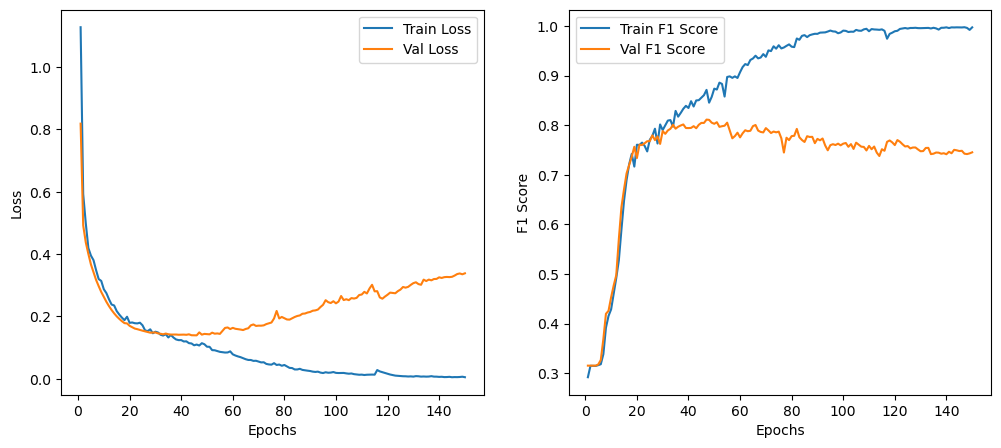

In [15]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, num_epochs + 1), val_f1_scores, label='Val F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.show()